# Welcome in this Jupyter Notebook.

This notebook is dedicated to simplify the collect of **Sentinel-3 SRAL L2 products** over river in a square area define by its center and a distance from the center (for exampl, the center can be the location of an in-situ station).


## First import libs

In [1]:
# Libs
import sys
import os
import numpy as np
from sentinelsat import SentinelAPI
import datetime as dt
from shapely import geometry
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
import zipfile
import netCDF4 as nc4
import pandas as pd

# visu
import matplotlib.pyplot as plt

## Then: here is the S3_HYDRO_DATA object

In [4]:
# S3 data object
class S3_HYDRO_DATA:
    """
        sentinel-3 data object
    """

    def __init__(self):
        """
            constructor
        """
        self.__user = ""
        self.__password = ""
        self.__api_url = 'https://apihub.copernicus.eu/apihub'
        self.relative_orbit_number = None
        self.product_file = None
        self.nc_file = None
        self.dataframe = None
        self.area = None

    # set user and password for the api
    def set_api_user(self, user, password) -> int:
        """
            set user and password for the compernicus apihub
        """
        self.__user = user
        self.__password = password

        return 0


    # set a box area of interest from lat/lon points and distance from the center
    def set_box_area_from_point(self, lon, lat, km_from_center=1.0) -> geometry.Polygon:
        """
            set area of interest from a point (lon/lat) and a radius in km
        """
        # draw the box
        lat_min = geod.Direct(lat, lon, 180, km_from_center*1000.0)['lat2']
        lat_max = geod.Direct(lat, lon, 0, km_from_center*1000.0)['lat2']
        lon_min = geod.Direct(lat, lon, 270, km_from_center*1000.0)['lon2']
        lon_max = geod.Direct(lat, lon, 90, km_from_center*1000.0)['lon2']
        bbox = geometry.box(lon_min, lat_min, lon_max, lat_max)

        return bbox


    # download sentinel-3 products
    def download_s3_l2_products(self, start_date, end_date, lon, lat, s3sat, relativeorbitnumber, timelineess='Non Time Critical', km_from_latlon=1.0) -> int:
        """
            download for sentinel-3 l2 prodcuts on the copernicus scihub
        """

        # define the area
        if km_from_latlon == 0.0:
            self.area = None
        else:
            self.area = self.set_box_area_from_point(lon, lat, km_from_center=km_from_latlon)

        # connect to the API
        api = SentinelAPI(user=self.__user, password=self.__password, api_url=self.__api_url)

        # set satellite
        filename_pattern = s3sat+'_SR_2_LAN__*'

        # earch by polygon, time, and Hub query keywords
        if self.area is None:
            products = api.query(date = (start_date, end_date),
                                 platformname = 'Sentinel-3',
                                 filename = filename_pattern,
                                 timeliness = timelineess,
                                 instrumentshortname= 'SRAL',
                                 productlevel = 'L2',
                                 relativeorbitnumber = relativeorbitnumber)
        else:
            products = api.query(area=self.area.wkt,
                                 date = (start_date, end_date),
                                 platformname = 'Sentinel-3',
                                 filename = filename_pattern,
                                 timeliness = timelineess,
                                 instrumentshortname= 'SRAL',
                                 productlevel = 'L2',
                                 relativeorbitnumber = relativeorbitnumber)
                                 
        # download all results from the search
        l_product = api.download_all(products)
        self.product_file = l_product[0][list(l_product[0].keys())[0]]['path']

        return 0


    # unzip file
    def __get_netcdf_file_from_product(self) -> int:
        """
            unzip the product file and get the netcdf
        """
        with zipfile.ZipFile(self.product_file, "r") as zip_ref:
            l_ncfiles = zip_ref.namelist()
            for ncfile in l_ncfiles:
                if "enhanced_measurement.nc" in ncfile:
                    self.nc_file = ncfile
                    zip_ref.extract(ncfile)
        if '/' in self.nc_file:
            self.nc_file = os.path.join(self.nc_file.split('/')[0], self.nc_file.split('/')[1])
        return 0


    # remove ncfile
    def remove_ncfile(self) -> int:
        """
            remove netcdf file
        """
        os.remove(self.nc_file)
        os.rmdir(os.path.split(self.nc_file)[0])
        return 0


    # remove product file
    def remove_product(self) -> int:
        """
            remove product file
        """
        os.remove(self.product_file)
        return 0


    # load s3data into a pandas dataframe
    def load_product_into_dataframe(self) -> pd.DataFrame:
        """
            unzip product and load netCDF file into pandas dataframe
        """
        # unzip product
        self.__get_netcdf_file_from_product()

        # read netcdf
        d_values = dict()
        with nc4.Dataset(self.nc_file) as nc:
            d_values['time'] = nc.variables['time_20_ku'][:]
            time_1 = nc.variables['time_01'][:]
            d_values['lat'] = nc.variables['lat_20_ku'][:]
            d_values['lon'] = nc.variables['lon_20_ku'][:]
            d_values['orbit'] = nc.variables['alt_20_ku'][:]
            d_values['range_ocog'] = nc.variables['range_ocog_20_ku'][:]
            d_values['range_ice'] = nc.variables['range_ice_20_ku'][:]
            # interp 1Hz data to 20 Hz 
            d_values['iono_cor'] = np.interp(d_values['time'], time_1, nc.variables['iono_cor_gim_01_ku'][:]) # 1 Hz -> 20 Hz
            d_values['dry_tropo'] = np.interp(d_values['time'], time_1, nc.variables['mod_dry_tropo_cor_meas_altitude_01'][:]) # 1 Hz -> 20 Hz
            d_values['wet_tropo'] = np.interp(d_values['time'], time_1, nc.variables['mod_wet_tropo_cor_meas_altitude_01'][:]) # 1 Hz -> 20 Hz
            d_values['solid_earth_tide'] = np.interp(d_values['time'], time_1, nc.variables['solid_earth_tide_01'][:]) # 1 Hz -> 20 Hz
            d_values['pole_tide'] = np.interp(d_values['time'], time_1, nc.variables['pole_tide_01'][:]) # 1 Hz -> 20 Hz

        # store into pandas dataframe
        df = pd.DataFrame.from_dict(d_values)

        # select data in the area
        lat_min = np.unique(self.area.boundary.xy[1]).min()
        lat_max = np.unique(self.area.boundary.xy[1]).max()
        df = df[(df['lat'] >= lat_min) & (df['lat'] <= lat_max)]

        return df


    def compute_wsh(self, df) -> pd.DataFrame:
        """
            compute wsh from s3data w.r.t to the reference ellipsoid (WGS84)
        """
        # comute wsh for the 2 retrackers: ice and ocog
        df['wsh_ocog'] = df['orbit'] - (df['range_ocog'] + df['iono_cor'] + df['dry_tropo'] + df['wet_tropo'] + df['solid_earth_tide'] + df['pole_tide'])
        df['wsh_ice'] = df['orbit'] - (df['range_ice'] + df['iono_cor'] + df['dry_tropo'] + df['wet_tropo'] + df['solid_earth_tide'] + df['pole_tide'])

        return df


## MAIN PROGRAM

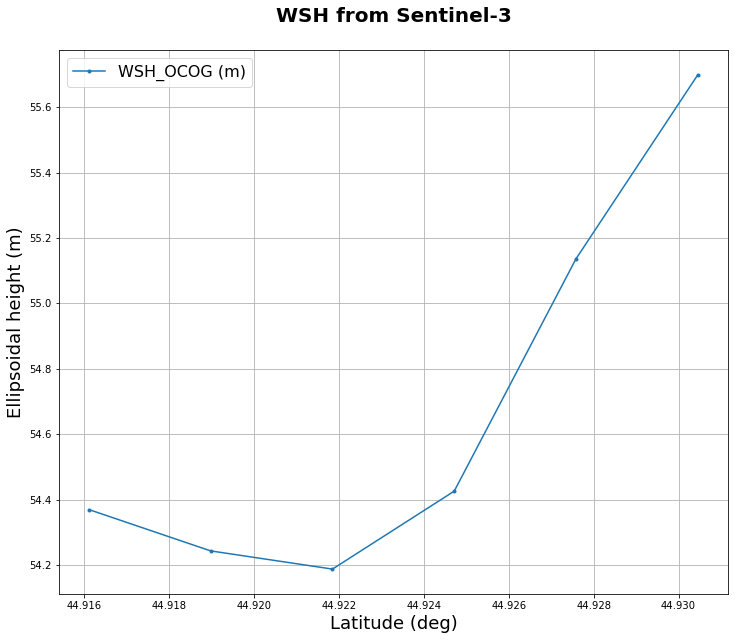

In [5]:
# create object
s3data = S3_HYDRO_DATA()

# set api login/passwd
s3data.set_api_user('jpoisson', 'millencolin')

# download data
start_date = dt.datetime(2022, 6, 1)
end_date = dt.datetime(2022, 6,30)
s3data.download_s3_l2_products(start_date, end_date, 10.611063, 44.922418, 'S3A', relativeorbitnumber=79)
df = s3data.load_product_into_dataframe()
df = s3data.compute_wsh(df)

# remove download file
# s3data.remove_ncfile()
# s3data.remove_product()

# visu
plt.figure(figsize=(12,10))
plt.plot(df['lat'], df['wsh_ocog'], '.-', label='WSH_OCOG (m)')
plt.xlabel("Latitude (deg)", fontsize=18)
plt.ylabel("Ellipsoidal height (m)", fontsize=18)
plt.title("WSH from Sentinel-3\n", fontsize=20, fontweight='bold')
plt.grid()
plt.legend(loc='best', fontsize=16)

plt.show()